In [1]:
import scipy
import h5py
import numpy as np
from pymatreader import read_mat
import mne
import tensorflow as tf
import pickle
import lzma
import blosc
import sys
from eelbrain import *
from scipy.io import wavfile
import librosa    
from tqdm import tqdm

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

C:\Users\gauta\anaconda3\envs\tf2\lib\site-packages\eelbrain\mne_fixes\_interpolation.py:13: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels
C:\Users\gauta\anaconda3\envs\tf2\lib\site-packages\eelbrain\mne_fixes\_interpolation.py:13: FutureWarning: mne.io.pick.pick_channels is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels


In [2]:
X = np.load('X.npy')

In [3]:
y = np.load('y.npy')

In [4]:
att = np.load('attended.npy')

In [5]:
mas = np.load('masker.npy')

In [6]:
lab = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2','AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2','EXG1','EXG2']

In [7]:
datapoints = 20

In [8]:
def resample_envelope(filename):
    data,samp = librosa.load(filename,sr=8000)
    #data = scipy.signal.resample(data,16*1024)
    data = np.abs(scipy.signal.hilbert(data))
    data = scipy.signal.resample(data,4224)
    return data

In [9]:
eeg = X[0:datapoints,:,5*128:38*128]
attended = list(map(resample_envelope,att[0:datapoints]))
masker = list(map(resample_envelope,mas[0:datapoints]))

In [10]:
attended = np.asarray(attended,dtype = np.float64)
masker = np.asarray(masker,dtype = np.float64)

In [11]:
del X,y

In [12]:
print(attended.dtype)
print(masker.dtype)
print(eeg.dtype)

float64
float64
float64


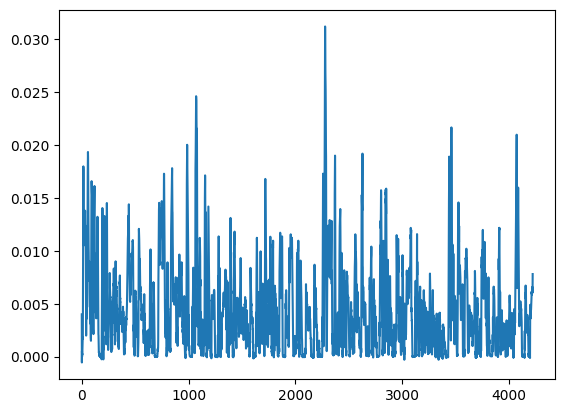

In [13]:
plt.plot(masker[0])

In [14]:
def create_NDVar(eeg,attended,masker,start,size):
    tstep = 1. / 128
    n_times = size
    time = UTS(0, tstep, n_times)
    sensor = Sensor.from_montage('mgh70')[:66]
    attended = NDVar(attended[start:start+size], (time,), name='attended')
    EEG= NDVar(eeg[:,start:start+size], (sensor,time), name='EEG', info={'unit': 'µV'})
    masker = NDVar(masker[start:start+size], (time,), name='masker')
    return EEG,attended,masker

In [15]:
##Training
res = []
err = []
for i in range(5):
    res1 = []
    for j in range(0,22):
        start = j*192
        size = 192
        eeg_x,att_wav,_ = create_NDVar(eeg[i],attended[i],masker[i],start,size)
        trf = boosting(att_wav,eeg_x,-0.3,0,basis=0.1,partitions = 4,scale_data='inplace')
        res1.append(trf)
        print(trf.r_rank)
    
    res.append(res1)

0.49111533627662657
0.19321040344923915
0.560572991791547
0.8227997808642971
0.8420740549772807
0.5182031824654307
0.4326451231391975
0.5719796332699558
0.438059806126883
0.2558998405127484
0.41358491175419565
0.6206889884309239
0.33758126115494846
0.48719989687731624
0.30434023666488386
0.6624182269343559
0.7114047243079502
0.6979214334053043
0.6232733515475429
0.7340229774884987
0.688076506571877
0.8094389481486256
0.4627437079049982
0.5066903864697796
0.0
0.3549405070257565
0.6143082723727885
-0.0634527785968525
0.5668976185105218
0.7259031291289355
0.5989171944510278
0.6541982888653197
0.529982920305501
0.0
0.6652078986382832
0.47751957265657835
0.4475940182155112
0.6949332257569514
0.6060939060939061
0.5100113676739173
0.27753536785794847
0.8513486513486513
0.5078856627243724
0.5225451967387452
0.09631014147143178
0.23434162778561243
0.6108214366278882
0.14052172635923404
0.6671876510586189
0.6892945763913506
0.0
0.7208875330708383
0.5530267878885357
0.8423705326931133
0.639241403

In [16]:
trf = sum([x.h_scaled for p in res for x in p])/(3*len(res[0]))

In [33]:
trf = res[0][0].h_scaled

In [27]:
k = sum([x.h_scaled for x in res])/len(res)

In [34]:
def predict(trf,eeg,attended,masker,start,size):
    start = start*192
    eeg,attended,masker = create_NDVar(eeg,attended,masker,start,size)
    pred = convolve(trf,eeg)
    peara = scipy.stats.pearsonr(pred,attended)
    print(peara.statistic)
    pearm = scipy.stats.pearsonr(pred,masker)
    if peara.statistic>pearm.statistic:
        return 1
    else:
        return 0

In [39]:
total = 0
for i in range(5,20):
    corr = 0
    for k in range(0,22):
        corr += predict(trf,eeg[i],attended[i],masker[i],k,192)
    print(corr)
    if (corr/22)>0.5:
        total+=1
    

0.14603487678031918
0.2180202874159849
0.23918957364881366
-0.39352544968976766
-0.2125561213230202
-0.32892903479805913
-0.25984539379646343
0.08029951290120527
-0.1784497993804869
-0.045043664444257836
-0.07194782269769948
0.09326916226799907
-0.11181180335967719
0.14590761867928592
-0.08650795710697101
-0.03039951520667864
0.04118033746459532
0.3600142478351666
0.2488606799640998
-0.34321038592012443
0.17303542549623
-0.25053113596112764
13
-0.2333233406281976
-0.4072307996698692
0.19615700123147314
0.23382933508121087
-0.12572131420915755
0.18656136763693415
-0.15373502514917242
-0.18031761270515376
0.08621407986599634
0.15002685177676536
0.38879893612083793
0.3431742131816769
0.14658416463090362
0.22252947307306073
-0.08034802953779777
-0.06448402309614465
0.07348998805249363
0.14841554163865445
0.11287463690913531
0.023552390907181624
-0.020978951041183073
-0.13218691375160674
12
-0.06960712516121076
-0.12310172576786309
0.29088340129736073
-0.19378640798815305
-0.039789443560527

In [40]:
def plot(trf,eeg,attended,masker,start = 0 ,stop = 400):
    eeg,attended,masker = create_NDVar(eeg,attended,masker,start,size=192)
    pred = convolve(trf,eeg).x

    plt.plot(np.abs(pred))
    plt.plot(attended.x)
    plt.plot(masker.x)
    return None

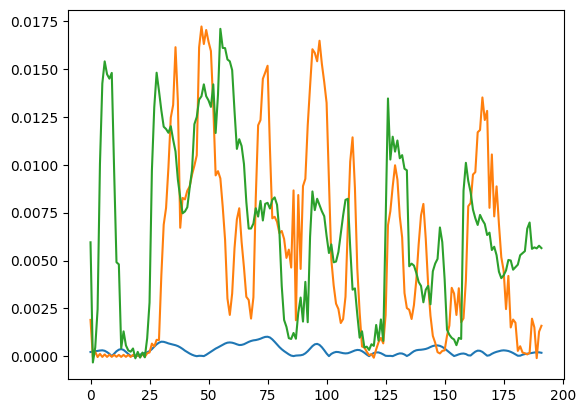

In [41]:
plot(trf,eeg[19],attended[19],masker[19])

In [38]:
total

0

In [306]:
scipy.stats.pearsonr(data[0],k)

PearsonRResult(statistic=-0.024667635656146932, pvalue=0.10893996286994899)

In [4]:
masker = mas['j']

In [6]:
masker = np.asarray(masker)
masker = masker.reshape(-1)


In [9]:
masker = list(map(lambda x: x[0:28] + "\\Files_Audio\\" + x[28:],masker))

In [10]:
masker

['C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_10_Borgmestrene_Det_er_dr_nhamrende _ Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_14_S_rlig_indsats_til_ledige_over_50_r_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_13_Boligpolitisk_proces_skudt_i_gang_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_35_Mere_gang_i_den_p_Torvet_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\M3_17_Stoholm_politiker_afl_ser_i_folketinget_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_16_Ny_gadeplansmedarbejder_skal_f_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_17_Br_ndby_Kommune_er_tavs_i_ridecentersag_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_08_Vi_har_ikke_parallelsamfund_i_Kolding_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_14_Kolding_s_tter_turbo_p_at_tiltr_kke_Pause02.wav',
 'C:\\Users\\gauta\\Thesis\\ExJobb\\Files_Audio\\F1_29_Fitness_s

In [11]:
np.save('masker.npy',masker)